Notebook to test kernel moment matching with a GAN generator.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import cadgan
import cadgan.kernel as kernel
import cadgan.glo as glo
import cadgan.main as main
import cadgan.net.net as net
import cadgan.gen as gen
import cadgan.plot as plot
import cadgan.embed as embed
import cadgan.util as util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

## Feature extractor for MNIST

In [5]:
cnn_model_fname = 'mnist_cnn_ep40_s1.pt'
model_path = glo.share_path('prob_models', 'mnist_cnn', cnn_model_fname)
# load the model
import cadgan.mnist.classify as mnist_classify
from cadgan.mnist.classify import MnistClassifier

# load option depends on whether GPU is used
load_options = {'map_location': lambda storage, loc: storage.cuda(0)} if use_cuda \
    else {'map_location': lambda storage, loc: storage} 

classifier = mnist_classify.MnistClassifier.load(model_path, **load_options)
classifier = classifier.eval()
classifier = classifier.to(device)
# classifier = classifier.cuda()

def extractor_maker(classifier):
    """
    Constructor and return a CNN-based feature extractor of type 
    cadgan.net.net.ModuleAdapter
    """    
    def extractor(imgs):
        """
        Feature extractor. This function should be as self-contained 
        (in its own lexical scope ) as possible since we will serialize
        it.
        """
        import torch.nn.functional as F
    #     return classifier.features(imgs)
        x = imgs
        x = F.relu(F.max_pool2d(classifier.conv1(x), 2))
        x = F.relu(F.max_pool2d(classifier.conv2(x), 2))
#         x = x.view(imgs.shape[0], -1)
        
        x = x.view(-1, 320)
        x = F.relu(classifier.fc1(x))
#         x = classifier.fc2(x)
        x = x.view(imgs.shape[0], -1)
        
    #     x = x.view(-1, 10*12*12)
    #     x = F.relu(self.fc1(x))
        return x
    adapter = net.ModuleAdapter(extractor)
    return adapter


/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
# Get an extractor
cnn_extractor = extractor_maker(classifier)
extractor = cnn_extractor

# Save the extractor as an object of type cadgan.net.net.ModuleAdapter
extractor_fname = 'mnist_l2_cnn.pt'
extractor_fpath = glo.share_path('prob_models', 'mnist_cnn', extractor_fname)
print('Saving the extractor to', extractor_fpath)
extractor.save(extractor_fpath)

Saving the extractor to /is/ei/wittawat/Gdrive/condgan_share/prob_models/mnist_cnn/mnist_l2_cnn.pt


In [7]:
# load MNIST data
mnist_folder = glo.data_file('mnist')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, train=False, download=True,
                        transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ]))

features:  tensor([[-5.1387, -4.1121, -4.8062, -3.9273, -1.5928, -2.9300, -5.4423, -2.9909,
         -1.8853, -0.7199]], grad_fn=<LogSoftmaxBackward>)


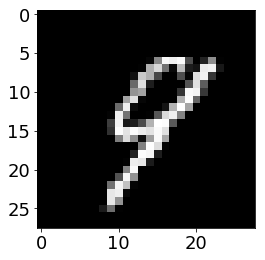

In [8]:
xy = mnist_dataset[92]
x = xy[0]
x = x.unsqueeze(0)
x = x.to(device)

# plot
xnp = x.cpu().numpy()
np.transpose(xy[0].numpy(), (1, 2, 0))
xnp = xnp.squeeze()
plt.imshow(xnp, cmap=plt.cm.Greys_r)
print('features: ', classifier(x))

## A generator for MNIST

In [9]:
import cadgan.mnist.dcgan as mnist_dcgan

gan_fname = 'mnist_dcgan_ep{}_bs{}.pt'.format(40, 64)
gan_fpath = glo.prob_model_folder('mnist_dcgan', gan_fname)

# load a model
g = mnist_dcgan.Generator.load(gan_fpath, **load_options)
g = g.eval().to(device)

# transform the output range of g to (0,1)
g = nn.Sequential(g, gen.LinearRangeTransform(from_range=(-1, 1), to_range=(0,1)))


latent_dim = 100
def f_noise_creator(latent_dim, device=device, tensor_type=tensor_type):
    return lambda n: torch.randn(n, latent_dim).to(device).type(tensor_type)
f_noise = f_noise_creator(latent_dim=latent_dim, device=device, tensor_type=tensor_type)

/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'cadgan.mnist.dcgan.Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retr

In [10]:
## Save the generator as type gen.PTNoiseTransformer
out_shape = g(f_noise(1)).shape[1:]
in_out_shapes = (latent_dim, out_shape)
g_ptnt = gen.PTNoiseTransformerAdapter(g, f_noise, in_out_shapes, tensor_type)

/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [11]:
# save as a PTNoiseTransformer object
ptnt_save_fname = 'ptnt_'+gan_fname

g_ptnt.save(glo.prob_model_folder('mnist_dcgan', ptnt_save_fname))

Show samples from the model

/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


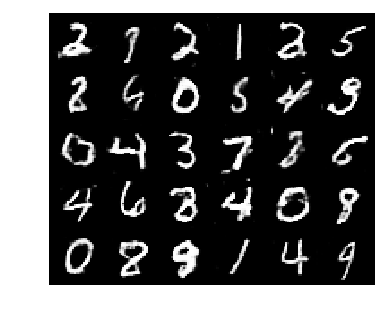

In [12]:
# initial points in the latent space
# n_sample = 2*2**3
n_sample = 5*6
# noise vectors
Z = f_noise(n_sample)
Z = Z.to(device)

Z.requires_grad = True
Y0 = g(Z)

# plot the initial points in the image space
plot.show_torch_imgs(Y0.detach(), nrow=6)
plt.axis('off')
plt.savefig('dcgan_samples.pdf', bboxes_inches='tight')

## Optimize points jointly to minimize the moment matching loss

With a GAN generator. Optimize in the latent space.

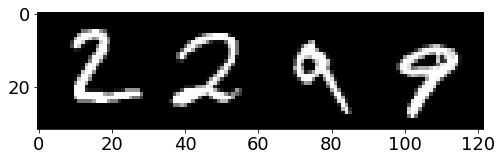

In [13]:
def sample_by_labels(data, label_counts):
    """
    data: a dataset such that data[i][0] is a point, and data[i][1] is an integer label.
    label_counts: a list of tuples of two values (A, B), where A is a label, and B is the count.
    """
    list_selected = []
    labels = np.array([data[i][1] for i in range(len(data))])
    for label, count in label_counts:
        inds = np.where(labels==label)[0]
        homo_data = [data[i][0] for i in inds[:count]]
        list_selected.extend(homo_data)
    # stack all
    selected = torch.stack(list_selected)
    return selected

# The set of points representing the mean embedding that we want to sample from.
# As an example, we will construct this manually.
# img_indices = [2, 5, 9, 12, 14, 16, 17, 20, 26, 29, 31, 34, 36, 37]
# img_indices = [2, 5, 14, 29, 31, 37, 39, 40, 46, 57]
# img_indices = [3, 5]
# X = torch.stack([mnist_dataset[i][0] for i in img_indices], dim=0)

label_counts = [(2, 2), (9, 2)]
# label_counts = [(4, 1)]
# label_counts = [(1, 2), (7, 1)]
# label_counts = [(6, 1), (9, 2)]
# label_counts = [(5, 2), (7, 1)]
# label_counts = [(3, 2)]
# label_counts = [(3, 1), (8, 1)]
# label_counts = [(6, 2), (3, 1)]
# label_counts = [(5, 1)]
# label_counts = [(1,1), (2,1), (3,1), (4,1)]
# label_counts = [(i, 5) for i in range(10)]
# label_counts = [(0, 6)]
X = sample_by_labels(mnist_dataset, label_counts)
X = X.to(device)
n = X.shape[0]

# A vector of weights for all the points in X
weights = torch.ones(n)/float(n)
weights = weights.to(device)
plot.show_torch_imgs(X)

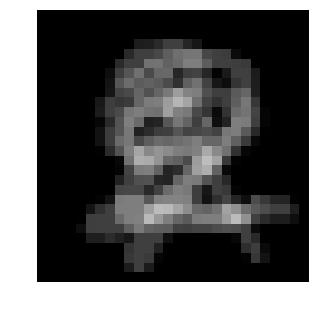

In [41]:
plot.show_torch_imgs(torch.mean(X, 0))
plt.axis('off')

cond_summ = '+'.join('{}_{}'.format(d, c) for d,c in label_counts)
plt.savefig('mnist-{}-mean.pdf'.format(cond_summ), bbox_inches='tight')

/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


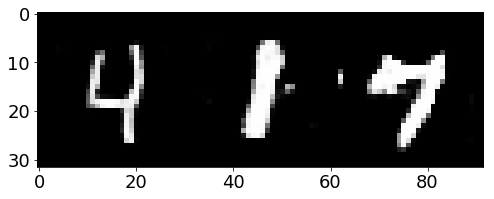

In [42]:
# initial points in the latent space
# n_sample = 2*2**3
n_sample = 3*1
# noise vectors
Z = f_noise(n_sample)
Z = Z.to(device)

Z.requires_grad = True
Y0 = g(Z)

# plot the initial points in the image space
plot.show_torch_imgs(Y0.detach(), nrow=8)

Choose an extractor

In [43]:
import cadgan.net.extractor as exmod

extractor_names = ['cnn', 'pixel']
extractors = [cnn_extractor, exmod.Identity(flatten=True)]

# Choose here
extractor_choice = 0
extractor = extractors[extractor_choice]
print('Using extractor: {}'.format(extractor_names[extractor_choice]))

Using extractor: cnn


In [44]:
# pre-extract the features of X. Fixed throughout the optimization
with torch.no_grad():
    FX = extractor(X)
    
# optimizer = torch.optim.SGD([Y], lr=5e-3)
# optimizer = torch.optim.RMSprop([Z], lr=5e-2)
optimizer = torch.optim.Adam([Z], lr=5e-2)

# kernel on the extracted features
# med = util.meddistance(FX.cpu().numpy(), subsample=1000)
# k = kernel.PTKGauss(sigma2=med**2)
# k = kernel.PTKPoly(c=1e-1, d=2)
k = kernel.PTKIMQ(b=-0.5, c=10)
# k = kernel.PTKLinear()

# kernel on the latent noise vectors
# k = kernel.PTKFuncCompose(kgauss, classifier)


/is/ei/wittawat/anaconda3/envs/cadgan/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


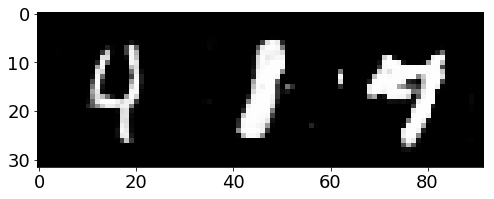

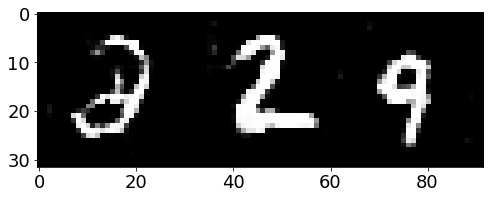

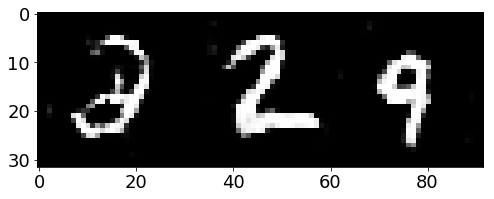

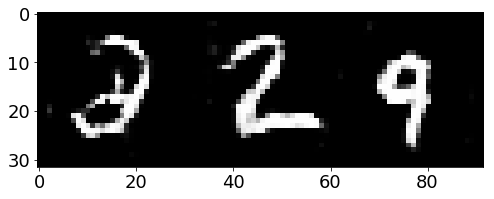

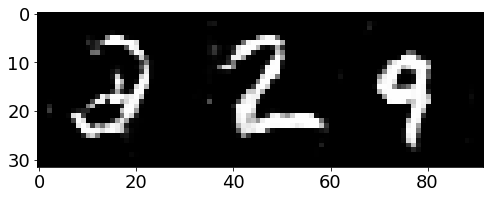

In [45]:
# optimization
n_iter = 1000
losses = []
sample_interval = 200
# avgpool = torch.nn.AvgPool2d(5, stride=1, padding=0)

mean_KFX = torch.mean(k.eval(FX, FX))
for t in range(n_iter):
    # need to resize since Mnist uses 28x28. The generator generates 32x32
    gens = g(Z)
#     resized = torch.stack([resize_gen_img(I) for I in gens], 0)
#     resized = avgpool(gens)
#     plot.show_torch_imgs(resized)
    F_gz = extractor(gens)
    KF_gz = k.eval(F_gz, F_gz)
#     print(KF_gz)
    
    # encourage the latent noise vectors to concentrate around 0
#     Z_reg = 1e-6*torch.mean(torch.sum(Z**2, 1))
    
    Z_reg = 0
#     Z_reg = -1e-5*torch.mean(torch.log(3.5**2-Z**2))
    
    loss = torch.mean(KF_gz)  - 2.0*torch.mean(k.eval(F_gz, FX).mv(weights)) + mean_KFX  + Z_reg
    losses.append(loss.item())
    
    optimizer.zero_grad()
    Z.data.clamp_(-3.5, 3.5)
    # compute the gradients
    loss.backward(retain_graph=True)
    # updates
    optimizer.step()
    
    #--------- plots the generated images ----
    if t%sample_interval==0:
        with torch.no_grad():
            gen_show = g(Z.detach().clone())
#             gen = Z.detach().clone()
#             gen = Z.grad.detach().clone()
            plot.show_torch_imgs(gen_show, normalize=True)
            plt.show()
    

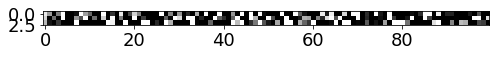

In [46]:
plot.show_torch_imgs(Z)

In [47]:
def prob_summary_key():
    """
    Return a key (e.g., for file naming) that summarizes roughly the hyperparameters chosen.
    """
    ext_name = extractor_names[extractor_choice]
    kernel_name = k.__class__.__name__
    cond = '+'.join('{}_{}'.format(d, c) for d,c in label_counts)
    s = 'mnist-{}-{}-{}-n{}'.format(cond,ext_name, kernel_name, n_sample)
    return s

prefix_fname = prob_summary_key()
print(prefix_fname)

mnist-2_2+9_2-cnn-PTKIMQ-n3


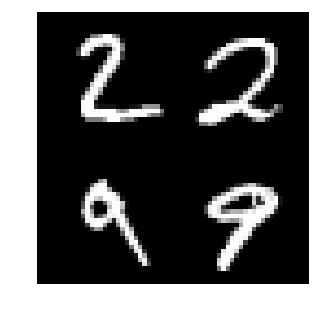

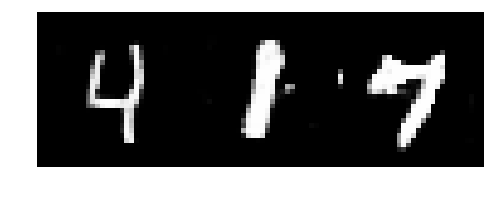

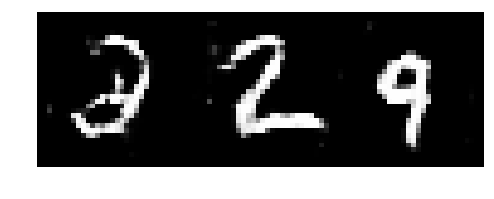

In [48]:
# input points
plot.show_torch_imgs(X, nrow=2)
# plt.title('Input')
plt.axis('off')
plt.savefig('{}-cond.pdf'.format(prefix_fname), bbox_inches='tight')

plot.show_torch_imgs(Y0.detach(), nrow=4)
# plt.title('Initialized')
plt.axis('off')
plt.savefig('{}-init.pdf'.format(prefix_fname), bbox_inches='tight')

plot.show_torch_imgs(gen_show, nrow=4)
# plt.title('Output')
plt.axis('off')
plt.savefig('{}-out.pdf'.format(prefix_fname), bbox_inches='tight')

Text(0,0.5,'MMD loss')

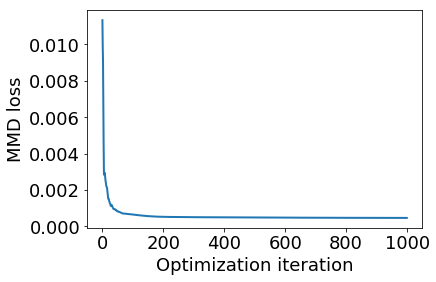

In [49]:
plt.plot(losses)
plt.xlabel('Optimization iteration')
plt.ylabel('MMD loss')

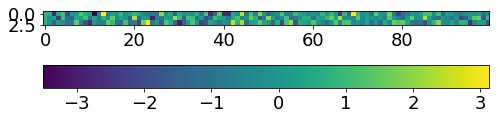

In [50]:
plt.figure(figsize=(8,5))
plt.imshow(Z.cpu().detach().numpy())
plt.colorbar(orientation='horizontal')